In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, resnet_model, utils, metrics, train
from fairface_classification.data import Unnormalize

# launch tensorboard writer
# writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
resnet = resnet50(weights='IMAGENET1K_V1')
train_label.head()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s] 


,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [3]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [4]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 
                                         'gender' : gender_dict, 
                                         'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, 
                                           {'age_dict' : age_dict, 
                                            'race_dict' : race_dict, 
                                            'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [5]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels = train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], 
                                 axis=1)
train_labels.head()

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041


In [6]:
root_dir = Path('..')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 64

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Resize((224, 224))
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Resize((224, 224))
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Resize((224, 224))
                                                                   ]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

### Train the backbone of ResNet50 on FairFace with Contrastive Learning

In [7]:
import torch
from byol_pytorch import BYOL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet = resnet.to(device)

def create_models_dir():
    models_dir = Path('../models')
    if not models_dir.exists():
        models_dir.mkdir()
    return models_dir

learner = BYOL(
    resnet,
    image_size=224
)
learner = learner.cuda()
opt = torch.optim.Adam(learner.parameters(), lr=3e-4)
# Training loop
hist = []
num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch = {epoch}')
    running_loss = 0.0
    hist.append(list())
    pbar = tqdm(train_loader)
    for samples in pbar:
        images = samples['image'].to(device)
        loss = learner(images)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder

        hist[-1].append(loss.item())
        pbar.set_description(f"epoch: {epoch}, loss: {loss.item()}")

        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")
    torch.save(resnet.state_dict(), f'../models/improved-net_epoch{epoch}.pt')

create_models_dir()
# save your improved network
torch.save(resnet.state_dict(), '../models/improved-net.pt')

Epoch = 0


epoch: 0, loss: 0.1041673794388771: 100%|██████████| 1085/1085 [04:59<00:00,  3.62it/s] 


Epoch 1/5, Loss: 0.6404
Epoch = 1


epoch: 1, loss: 0.03467681631445885: 100%|██████████| 1085/1085 [04:58<00:00,  3.63it/s] 


Epoch 2/5, Loss: 0.3050
Epoch = 2


epoch: 2, loss: 0.2107522338628769: 100%|██████████| 1085/1085 [04:57<00:00,  3.64it/s]  


Epoch 3/5, Loss: 0.2283
Epoch = 3


epoch: 3, loss: 0.039716608822345734: 100%|██████████| 1085/1085 [04:59<00:00,  3.62it/s]


Epoch 4/5, Loss: 0.2070
Epoch = 4


epoch: 4, loss: 0.026781465858221054: 100%|██████████| 1085/1085 [04:58<00:00,  3.64it/s]


Epoch 5/5, Loss: 0.1658


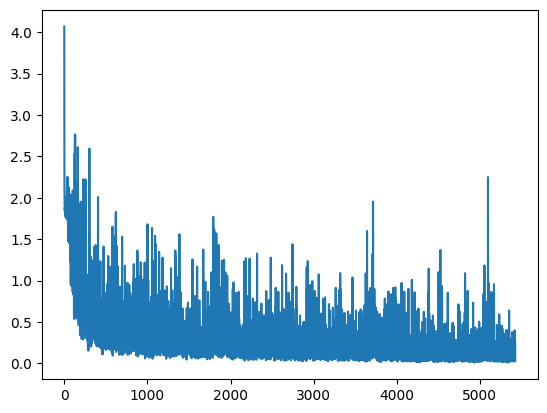

In [19]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

plt.plot(flatten_extend(hist))
plt.show()